In [1]:
from collections import defaultdict
import sys
import math
import re
import time
import pandas as pd 
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
from memory_profiler import profile
import psutil
from sklearn.preprocessing import LabelEncoder
from vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, 
    classification_report,
    precision_score, 
    recall_score, 
    f1_score,
)

In [2]:
# read csv and put into dataframe
df = pd.read_csv("amazon_reviews_3k.csv", encoding="UTF-8", nrows=1000)
df

,asin,name,date,rating,review
0,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-06,1,I bought this hair oil after viewing so many g...
1,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-14,5,Used This Mama Earth Newly Launched Onion Oil ...
2,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-10-19,1,So bad product...My hair falling increase too ...
3,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-16,1,Product just smells similar to navarathna hair...
4,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-18,5,I have been trying different onion oil for my ...
...,...,...,...,...,...
995,B0818ZYVH1,Patanjali-Kanti-Natural-Cleanser-Shampoo,2017-12-03,5,Made in bharat and we r proud of it...no harmf...
996,B0818ZYVH1,Patanjali-Kanti-Natural-Cleanser-Shampoo,2020-05-09,5,Superb shampoo so soft n delicate on hair. Bee...
997,B0818ZYVH1,Patanjali-Kanti-Natural-Cleanser-Shampoo,2016-10-01,5,Wonderful product. Using little produces enoug...
998,B0818ZYVH1,Patanjali-Kanti-Natural-Cleanser-Shampoo,2019-04-03,5,already used earlier. good item. no issue i fe...


In [3]:
# drop null values
df.dropna()
df = df.reset_index(drop=True)

In [4]:
# exxtract review column values 
X = df['review'].values
# initialize label encoder
le = LabelEncoder()

# check if dating column is present
if 'rating' in df.columns:
    # fit labelencoder to unique values in the 'rating' column
    le.fit(df['rating'].unique())

    # print result of unique classes encoded
    print(list(le.classes_))
    # transform 'rating' labels to numerical representations
    y = le.transform(df['rating'].values)

    # print info about data and labels
    print(X.shape)
    print(X[0])
    print(y.shape)
    print(y[0])
else:
    print("Column 'rating' not found in the DataFrame.")

[1, 2, 3, 4, 5]
(1000,)
I bought this hair oil after viewing so many good comments. But this product is not good enough.First of all it's Expensive...Second thing the amount of the product is low (half bottle) YES!The bottle is not completely filled with oil. If you cheating on your customers #Mamaearth trust me on this you can't fool people more than once. Now I know that your Brand is not good enough. I am not going to buy any product from your Brand again.Thumbs down for mamaearth onion oil !!
(1000,)
0


In [5]:
processed_reviews = []

# iterate through each review
for review in range(0, len(X)):
    # remove special characters
    processed_review = re.sub(r'\W', ' ', str(df['review'][review]))

    # remove single characters
    processed_review = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_review)
    processed_review = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_review)

    # remove multiple spaces
    processed_review = re.sub(r'\s+', ' ', processed_review, flags=re.I)

    # remove prefixed 'b' (if applicable, assuming X is a list of strings)
    processed_review = re.sub(r'^b\s+', '', processed_review)

    # convert to lowercase
    processed_review = processed_review.lower()

    # append to the empty list created earlier
    processed_reviews.append(processed_review)

# put all processed reviews into new column 
df['processed_reviews'] = processed_reviews

In [6]:
# before data cleaning
print(str(X[:5]))
print()

# after data cleaning
processed_reviews[:5]

df['processed_reviews']

["I bought this hair oil after viewing so many good comments. But this product is not good enough.First of all it's Expensive...Second thing the amount of the product is low (half bottle) YES!The bottle is not completely filled with oil. If you cheating on your customers #Mamaearth trust me on this you can't fool people more than once. Now I know that your Brand is not good enough. I am not going to buy any product from your Brand again.Thumbs down for mamaearth onion oil !!"
 'Used This Mama Earth Newly Launched Onion Oil twice, and i must say im already impressed by the results !It prevents hair loss, helps control premature greying, dryness, dandruff, scalp eruptions and many other hair problems after its regular use !To avoid dry and frizzy hair, make sure that you use this oil to your hairs twice a week.Oiling provides your scalp with essential nutrients, and also strengthens the hair roots. Mamaearth onion oil works best for your hair during all the seasons.'
 'So bad product...M

0      i bought this hair oil after viewing so many g...
1      used this mama earth newly launched onion oil ...
2      so bad product my hair falling increase too mu...
3      product just smells similar to navarathna hair...
4      i have been trying different onion oil for my ...
                             ...                        
995    made in bharat and we proud of it no harmful c...
996    superb shampoo so soft delicate on hair been u...
997    wonderful product using little produces enough...
998    already used earlier good item no issue felt t...
999    it not highly perfumed does wat an ayurvedic s...
Name: processed_reviews, Length: 1000, dtype: object

In [7]:
# set stopwords
stopWords = set(stopwords.words('english') + ['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from'])

def removeStopWords(stopWords, rvw_txt):
    newtxt = ' '.join([word for word in rvw_txt.split() if word.lower() not in stopWords])
    return newtxt


df['processed_reviews'] = df['processed_reviews'].astype(str)

# before stop words removed
print("Before removing stop words:")
print(df['processed_reviews'].head())

# apply removeStopWords function
df['clean_review_text'] = [removeStopWords(stopWords, x) for x in df['processed_reviews']]

# after stop words removed
print("\nAfter removing stop words:")
print(df['clean_review_text'].head())

Before removing stop words:
0    i bought this hair oil after viewing so many g...
1    used this mama earth newly launched onion oil ...
2    so bad product my hair falling increase too mu...
3    product just smells similar to navarathna hair...
4    i have been trying different onion oil for my ...
Name: processed_reviews, dtype: object

After removing stop words:
0    bought hair oil viewing many good comments pro...
1    used mama earth newly launched onion oil twice...
2    bad product hair falling increase much order s...
3    product smells similar navarathna hair oil str...
4    trying different onion oil hair hair healthy p...
Name: clean_review_text, dtype: object


In [8]:
# splitting text into words
tokenList=[]

# iterate over each row to tokenize the text in clean_review_text column
for indx in range(len(df)):
       token= word_tokenize(df['clean_review_text'][indx])
       tokenList.append(token)

df['review_tokens'] = tokenList
df.head()

,asin,name,date,rating,review,processed_reviews,clean_review_text,review_tokens
0,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-06,1,I bought this hair oil after viewing so many g...,i bought this hair oil after viewing so many g...,bought hair oil viewing many good comments pro...,"[bought, hair, oil, viewing, many, good, comme..."
1,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-14,5,Used This Mama Earth Newly Launched Onion Oil ...,used this mama earth newly launched onion oil ...,used mama earth newly launched onion oil twice...,"[used, mama, earth, newly, launched, onion, oi..."
2,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-10-19,1,So bad product...My hair falling increase too ...,so bad product my hair falling increase too mu...,bad product hair falling increase much order s...,"[bad, product, hair, falling, increase, much, ..."
3,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-16,1,Product just smells similar to navarathna hair...,product just smells similar to navarathna hair...,product smells similar navarathna hair oil str...,"[product, smells, similar, navarathna, hair, o..."
4,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-18,5,I have been trying different onion oil for my ...,i have been trying different onion oil for my ...,trying different onion oil hair hair healthy p...,"[trying, different, onion, oil, hair, hair, he..."


In [9]:
df["senti"] = df["rating"]>=4   # classifying text based on sentiments (positive or negative)
df["senti"] = df["senti"].replace([True , False] , ["pos" , "neg"])

In [10]:
sentiment_model = SentimentIntensityAnalyzer()
sentiment_scores=[]
sentiment_score_flag = []

# iterate over text and calculate sentiment
for text in df['clean_review_text']:
        sentimentResults = sentiment_model.polarity_scores(text)
        sentiment_score = sentimentResults["compound"]

        # append sentiment score and label
        sentiment_scores.append(sentiment_score)

        # marking the sentiments as positive, negative and neutral 
        if sentimentResults['compound'] >= 0.05 : 
            sentiment_score_flag.append('positive')
  
        elif sentimentResults['compound'] <= - 0.05 : 
            sentiment_score_flag.append('negative')
  
        else : 
            sentiment_score_flag.append('neutral')
            
# add into new column
df['scores'] = sentiment_scores
df['scoreStatus'] = sentiment_score_flag

<Axes: xlabel='scoreStatus', ylabel='count'>

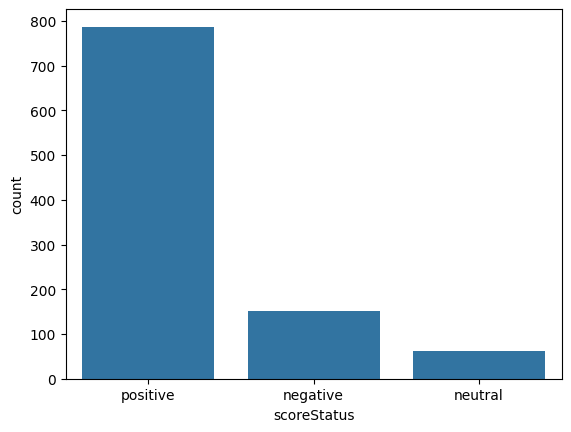

In [11]:
# visualize how much of each sentiment
sns.countplot(data=df, x="scoreStatus")

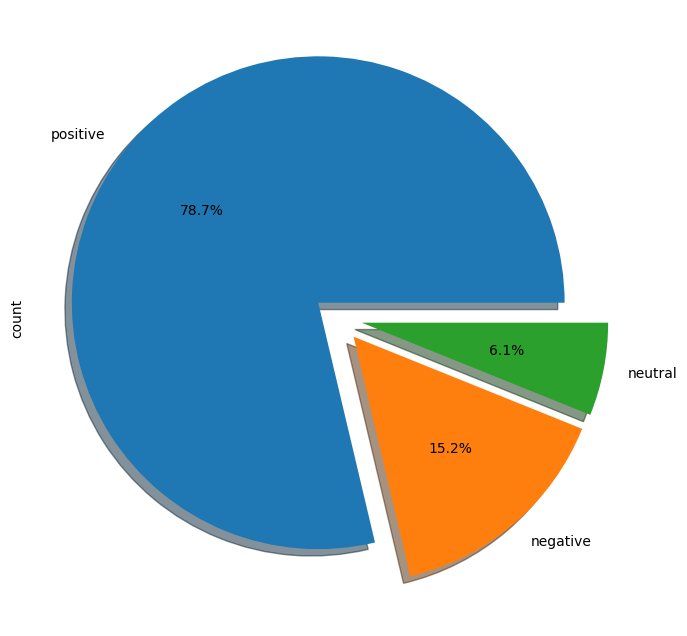

In [12]:
# pie plot
explode = [0.1, 0.1, 0.1]

df['scoreStatus'].value_counts().plot.pie(
    explode=explode,
    autopct='%1.1f%%',
    shadow=True,
    figsize=(10, 8)
)

plt.show()

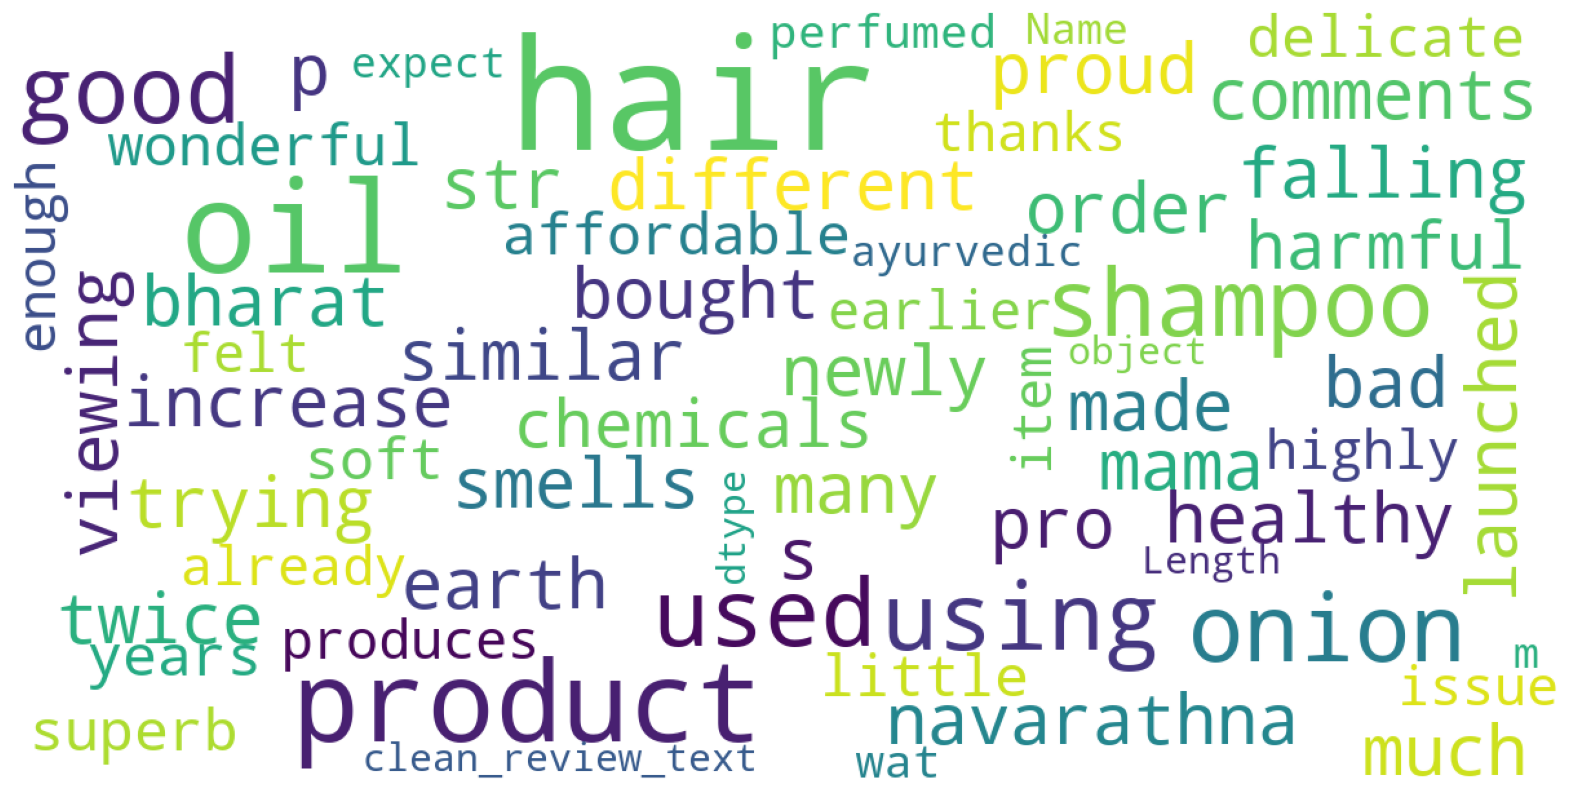

In [13]:
# wordcloud to visualize the words involved
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(df["clean_review_text"])

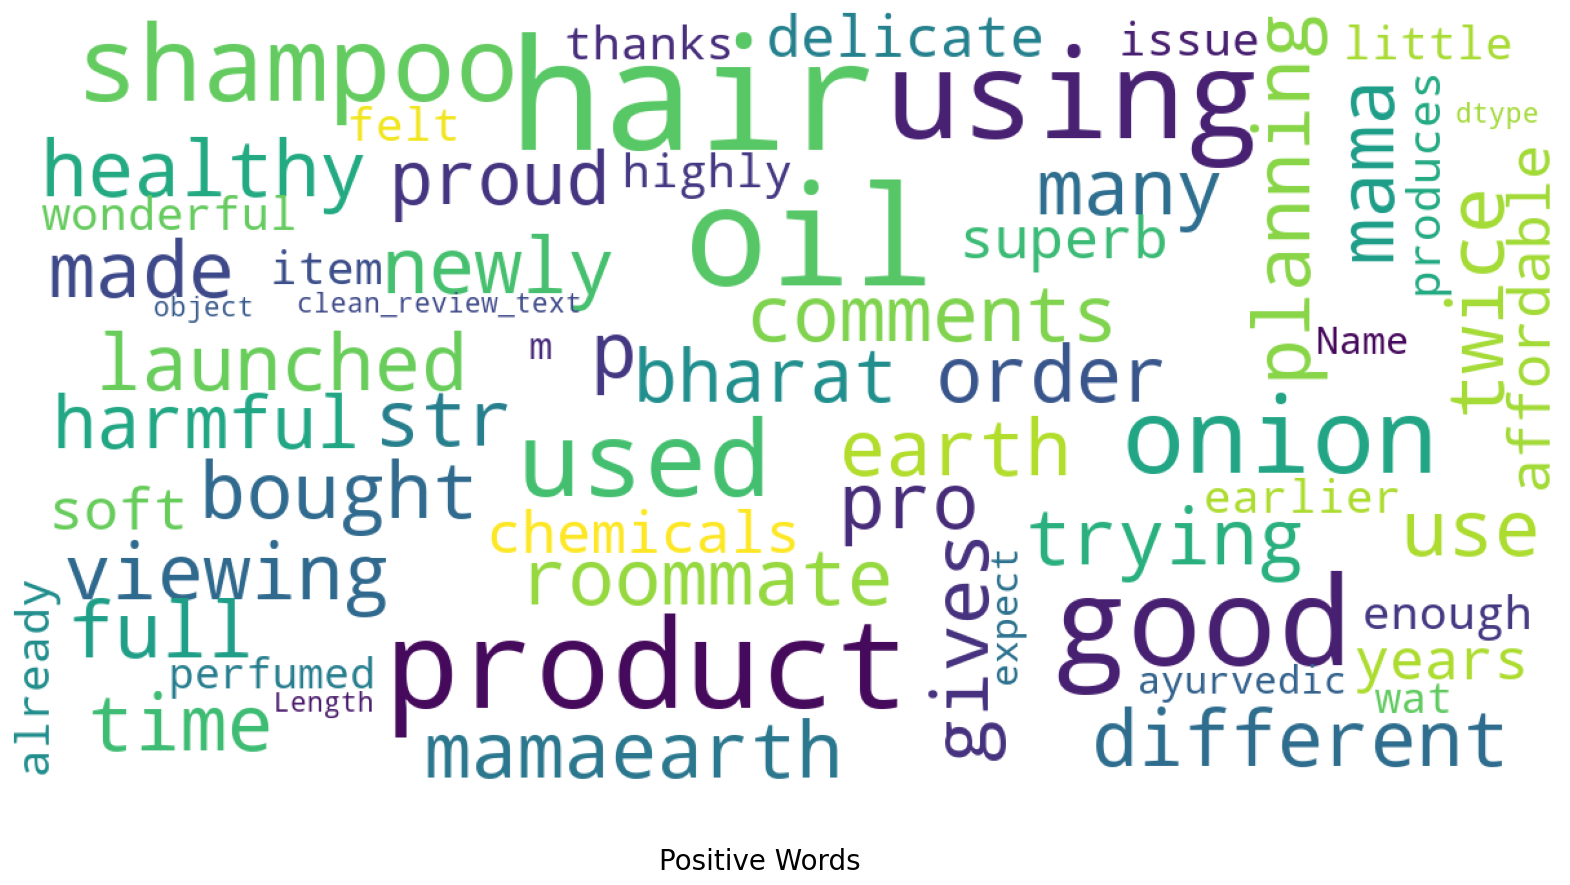

In [14]:
# wordcloud based on positive reviews
show_wordcloud(df["clean_review_text"][df.scoreStatus == "positive"] , title="Positive Words")

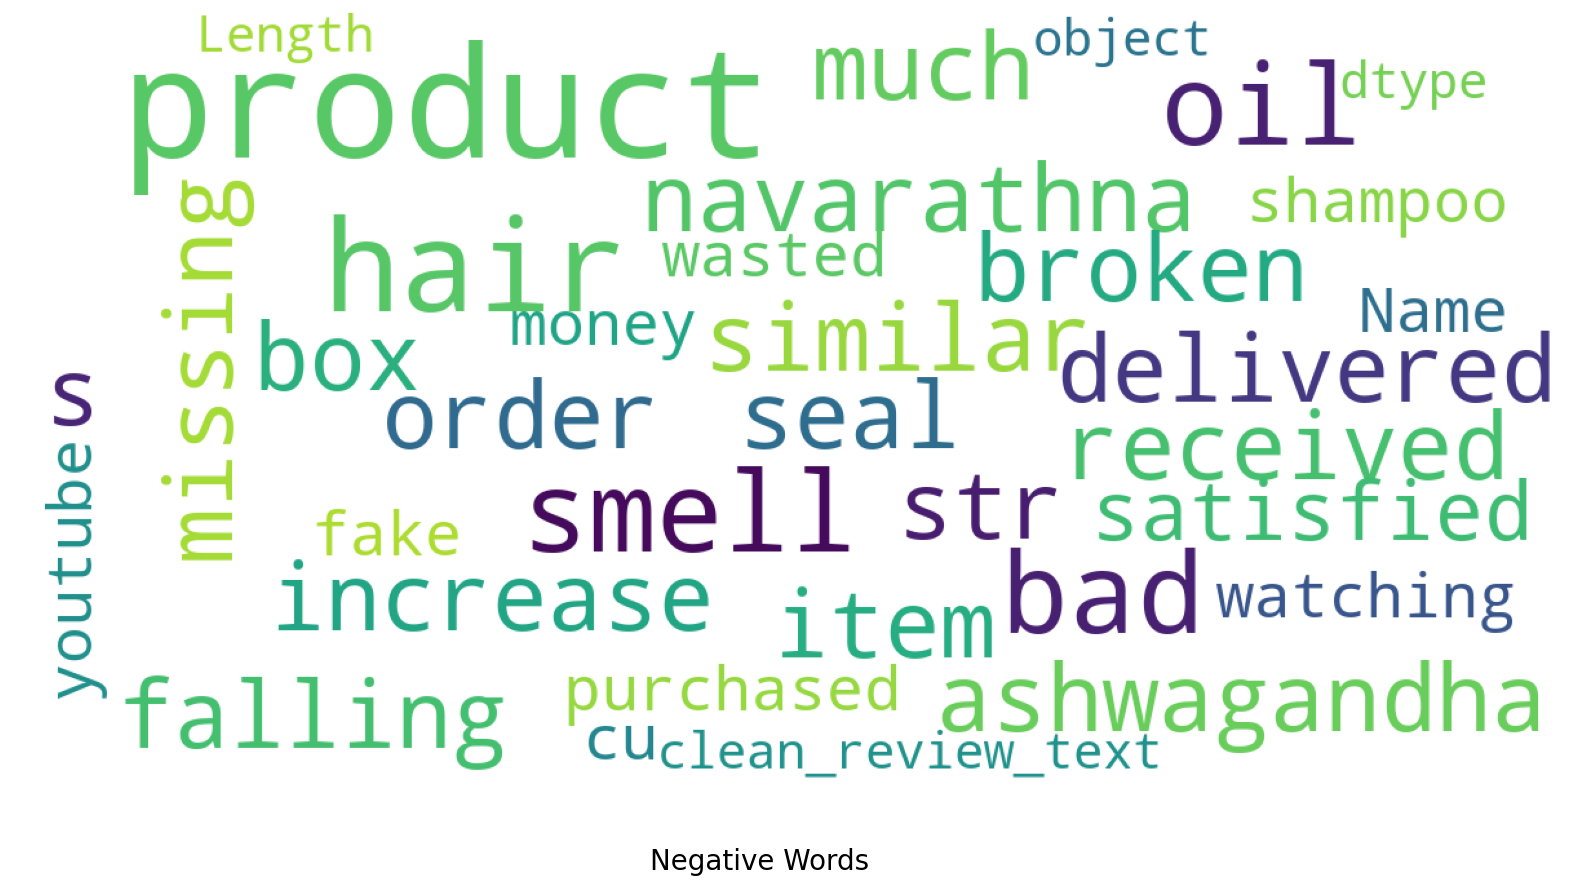

In [15]:
# wordcloud based on negative reviews
show_wordcloud(df["clean_review_text"][df.scoreStatus == "negative"] , title="Negative Words")

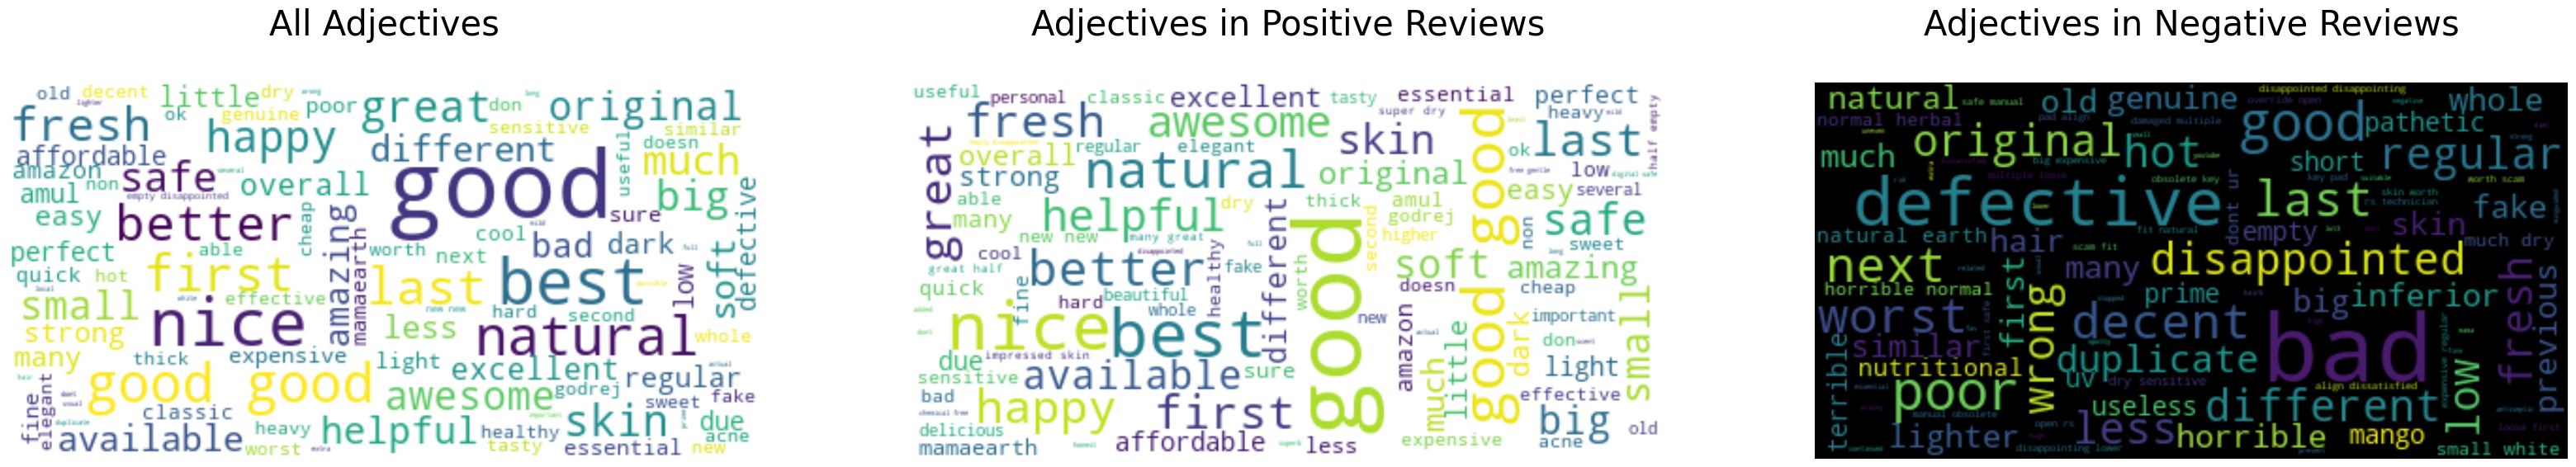

In [16]:
# extract adjectives from a text
def extract_adjectives(text):
    words = word_tokenize(text)
    tagged_words = pos_tag(words)
    adjectives = [word for word, pos in tagged_words if pos.startswith('JJ')]
    return ' '.join(adjectives)

df['processed_reviews'] = df['processed_reviews'].astype(str)

# apply  extract_adjectives function to each processed review
df['adjectives'] = df['processed_reviews'].apply(extract_adjectives)

df_pos = df[df['scoreStatus'] == 'positive'] 
df_neg = df[df['scoreStatus'] == 'negative']  

# concatenate all adjectives into a single string
adjectives_all = " ".join(review for review in df['adjectives'])
adjectives_pos = " ".join(review for review in df_pos['adjectives'])
adjectives_neg = " ".join(review for review in df_neg['adjectives'])

fig, ax = plt.subplots(1, 3, figsize=(40, 40))

# generate a word cloud image:
wordcloud_all = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(adjectives_all)
wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(adjectives_pos)
wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(adjectives_neg)

# display  generated images side by side:
ax[0].imshow(wordcloud_all, interpolation='bilinear')
ax[0].set_title('All Adjectives\n', fontsize=30)
ax[0].axis('off')
ax[1].imshow(wordcloud_pos, interpolation='bilinear')
ax[1].set_title('Adjectives in Positive Reviews\n', fontsize=30)
ax[1].axis('off')
ax[2].imshow(wordcloud_neg, interpolation='bilinear')
ax[2].set_title('Adjectives in Negative Reviews\n', fontsize=30)
ax[2].axis('off')

plt.show()

TF-IDF

In [17]:
# calculate the term frequency (TF)
def calculate_tf(documents):
    tf = defaultdict(lambda: defaultdict(int))

    for idx, doc in enumerate(documents):
        terms = doc.lower().split()  # tokenization and lowercasing
        total_terms = len(terms)
        for term in set(terms):  # using set to count each term only once
            tf[term][idx] = terms.count(term) / total_terms

    return tf

In [18]:
# calculate inverse document frequency (IDF)
def calculate_idf(tf, total_docs):
    idf = {}
    for term, doc_freq in tf.items():
        idf[term] = math.log10(total_docs / (1 + len(doc_freq)))
    return idf

In [19]:
# calculates the TF-IDF (Term Frequency-Inverse Document Frequency) 
def compute_tfidf(tf, idf):
    tfidf = defaultdict(lambda: defaultdict(float))

    for term, doc_freq in tf.items():
        for doc_idx, tf_score in doc_freq.items():
            tfidf[term][doc_idx] = tf_score * idf[term]

    return tfidf

In [20]:
# generates TF-IDF vectors
def create_tfidf_vectors(tfidf, num_documents):
    tfidf_vectors = []
    for doc_idx in range(num_documents):
        vector = [tfidf[term][doc_idx] for term in tfidf]
        tfidf_vectors.append(vector)
    return tfidf_vectors

In [21]:
# apply TF-IDF to the data
tf_dict = calculate_tf(df["clean_review_text"])
idf_dict = calculate_idf(tf_dict, len(df["clean_review_text"]))
tf_idf = compute_tfidf(tf_dict, idf_dict)
tf_idf_vectors = create_tfidf_vectors(tf_idf, len(df["clean_review_text"]))

# # print TF-IDF matrix
# print(tf_idf_vectors)

In [22]:
# check memory usage of applying TF-IDF to the data
def print_memory_usage():
    process = psutil.Process()
    memory_info = process.memory_info()

    print(f"Memory Usage: {memory_info.rss / (1024 ** 2):.2f} MB (Resident Set Size)")
    print(f"Virtual Memory: {memory_info.vms / (1024 ** 2):.2f} MB")

@profile
def calculate_tfidf_memory():
    tf_dict = calculate_tf(df["clean_review_text"])
    idf_dict = calculate_idf(tf_dict, len(df["clean_review_text"]))
    tf_idf = compute_tfidf(tf_dict, idf_dict)
    tf_idf_vectors = create_tfidf_vectors(tf_idf, len(df["clean_review_text"]))
    print_memory_usage()

calculate_tfidf_memory()

ERROR: Could not find file /var/folders/k7/hgkz89px7jz91sbyc7lxqdxh0000gn/T/ipykernel_45402/2256157381.py
Memory Usage: 265.86 MB (Resident Set Size)
Virtual Memory: 400912.55 MB


In [23]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf_vectors, df["scoreStatus"], test_size=0.2, random_state=42)

# initialize the classifier
clf = LinearSVC()

# train the classifier
clf.fit(X_train, y_train)

# make predictions on the test set
y_pred = clf.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy}")

# calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='micro')  # Choose the appropriate average setting
recall = recall_score(y_test, y_pred, average='micro')  # Choose the appropriate average setting
f1 = f1_score(y_test, y_pred, average='micro')  # Choose the appropriate average setting

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

# Classification report
report = classification_report(y_test, y_pred, zero_division=0)
print("\n",report)

Accuracy on test set: 0.85
Precision: 0.85
Recall: 0.85
F1-Score: 0.85

               precision    recall  f1-score   support

    negative       1.00      0.38      0.55        40
     neutral       1.00      0.50      0.67        10
    positive       0.83      1.00      0.91       150

    accuracy                           0.85       200
   macro avg       0.94      0.62      0.71       200
weighted avg       0.88      0.85      0.82       200



/Users/priscillaabigail/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [24]:
start_time = time.time()

# Code for training your model
clf.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time} seconds")

Training Time: 0.3316688537597656 seconds


/Users/priscillaabigail/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [25]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf_vectors, df["scoreStatus"], test_size=0.2, random_state=42)

# initialize the classifier
gnb = GaussianNB()

# train the classifier
gnb.fit(X_train, y_train)

# make predictions on the test set
y_pred = gnb.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy}")

# classification report
report = classification_report(y_test, y_pred, zero_division=0)
print("\n", report)

Accuracy on test set: 0.93

               precision    recall  f1-score   support

    negative       0.82      0.90      0.86        40
     neutral       1.00      0.80      0.89        10
    positive       0.96      0.95      0.95       150

    accuracy                           0.93       200
   macro avg       0.93      0.88      0.90       200
weighted avg       0.93      0.93      0.93       200



In [26]:
model_size = sys.getsizeof(clf)
print(f"Model Size: {model_size / (1024 * 1024)} MB")

Model Size: 4.57763671875e-05 MB


In [27]:
def predict_sentiment(new_text, model, tf_dict, idf_dict):
    # calculate TF for the new text
    terms = new_text.lower().split()
    total_terms = len(terms)
    tf_new_text = defaultdict(int)
    for term in set(terms):
        tf_new_text[term] = terms.count(term) / total_terms

    # calculate TF-IDF for the new text using IDF values from the entire corpus
    tfidf_new_text = defaultdict(float)
    for term, tf_score in tf_new_text.items():
        if term in idf_dict:
            tfidf_new_text[term] = tf_score * idf_dict[term]

    # create TF-IDF vector for the new text
    tfidf_vector_new_text = [tfidf_new_text[term] for term in tf_dict]

    # reshape to match the input format expected by the model (1 sample, n_features)
    tfidf_vector_new_text = [tfidf_vector_new_text]

    # predict sentiment using the trained model
    prediction = model.predict(tfidf_vector_new_text)
    return prediction[0]  # Assuming a single prediction for the new text

# example usage:
new_text = "The customer service was bad"
predicted_sentiment = predict_sentiment(new_text, clf, tf_dict, idf_dict)
print(f"Predicted sentiment: {predicted_sentiment}")

Predicted sentiment: negative


In [28]:
def predict_sentiment(new_text, model, tf_dict, idf_dict):
    # calculate TF for the new text
    terms = new_text.lower().split()
    total_terms = len(terms)
    tf_new_text = defaultdict(int)
    for term in set(terms):
        tf_new_text[term] = terms.count(term) / total_terms

    # calculate TF-IDF for the new text using IDF values from the entire corpus
    tfidf_new_text = defaultdict(float)
    for term, tf_score in tf_new_text.items():
        if term in idf_dict:
            tfidf_new_text[term] = tf_score * idf_dict[term]

    # create TF-IDF vector for the new text
    tfidf_vector_new_text = [tfidf_new_text[term] for term in tf_dict]

    # reshape to match the input format expected by the model (1 sample, n_features)
    tfidf_vector_new_text = [tfidf_vector_new_text]

    # predict sentiment using the trained model
    prediction = model.predict(tfidf_vector_new_text)
    return prediction[0]  # Assuming a single prediction for the new text

# example usage:
new_text = "The product was very good"
predicted_sentiment = predict_sentiment(new_text, clf, tf_dict, idf_dict)
print(f"Predicted sentiment: {predicted_sentiment}")

Predicted sentiment: positive
